In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
testset_name = "finals_weight_sharing"

# Define architectures with their path patterns
architectures = {
    "vanilla_n_stores": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores',
    "n_stores_shared_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net',
    "n_stores_per_store_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_per_store_net'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [8192, 1024, 128]
optimal_loss = 6.53  # Optimal loss value

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if 'master' in reference_row:
        out_row['master'] = reference_row['master']

def default_condition_setter(condition_name):
    return None

results_interpretor = rri.RayResultsinterpreter()

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    path = path_fn(None)
    condition_dict = {'train_dev_sample_and_batch_size': sample_sizes, 'n_stores': n_stores}
    df = results_interpretor.make_table({1: path},
        condition_dict,
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)

    if not df.empty:
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['# of stores'] = df['n_stores']
        # n_stores and # of stores columns will be set by make_table if present in the data
        dfs.append(df)
df = pd.concat(dfs)

import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'n_stores_lost_demand_optimal_test_loss.txt'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) + "/" + test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

    # of stores  train_dev_sample_and_batch_size Architecture Class  n_stores  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                                                                                                         path  master  Optimality Gap %
0             3                              128            Vanilla         3    6.498646  6.641177   6.589874        /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_weight_sharing/vanilla_n_stores/run_2025-04-28_11-32-15/run_f6668_00431_431_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-04-29_02-25-21   128.0          0.916902
0             3                              128                GNN         3    6.533234  6.607551   6.542469     /Users/minuk.lee/Downloads/Neural_invento

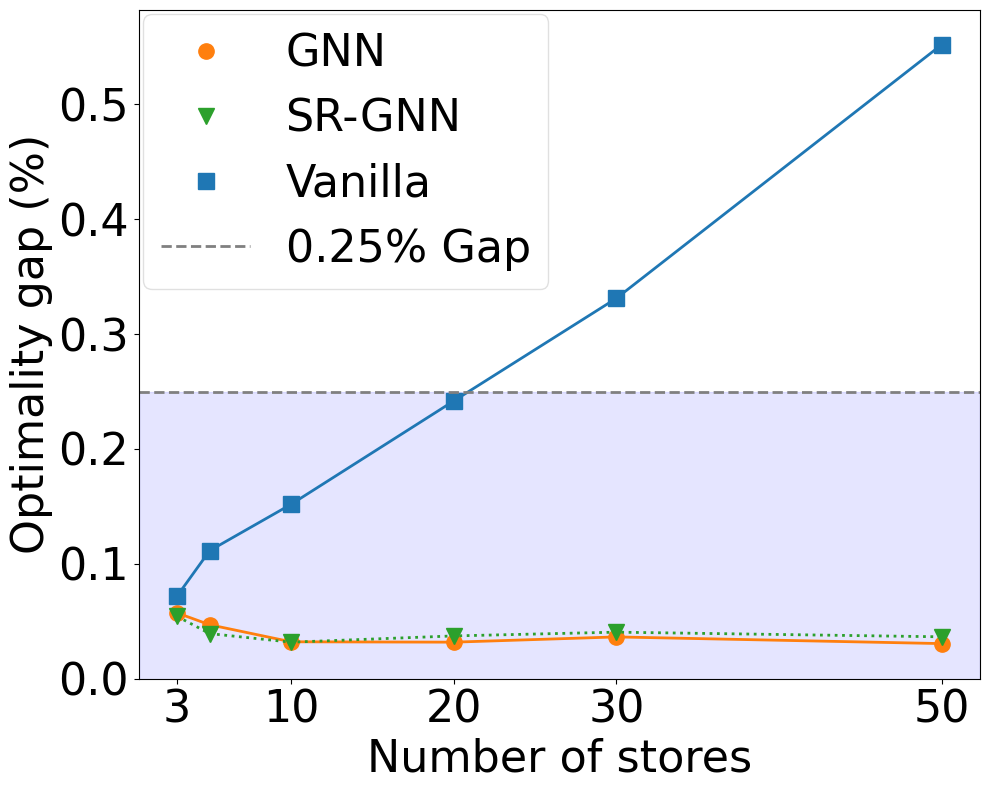

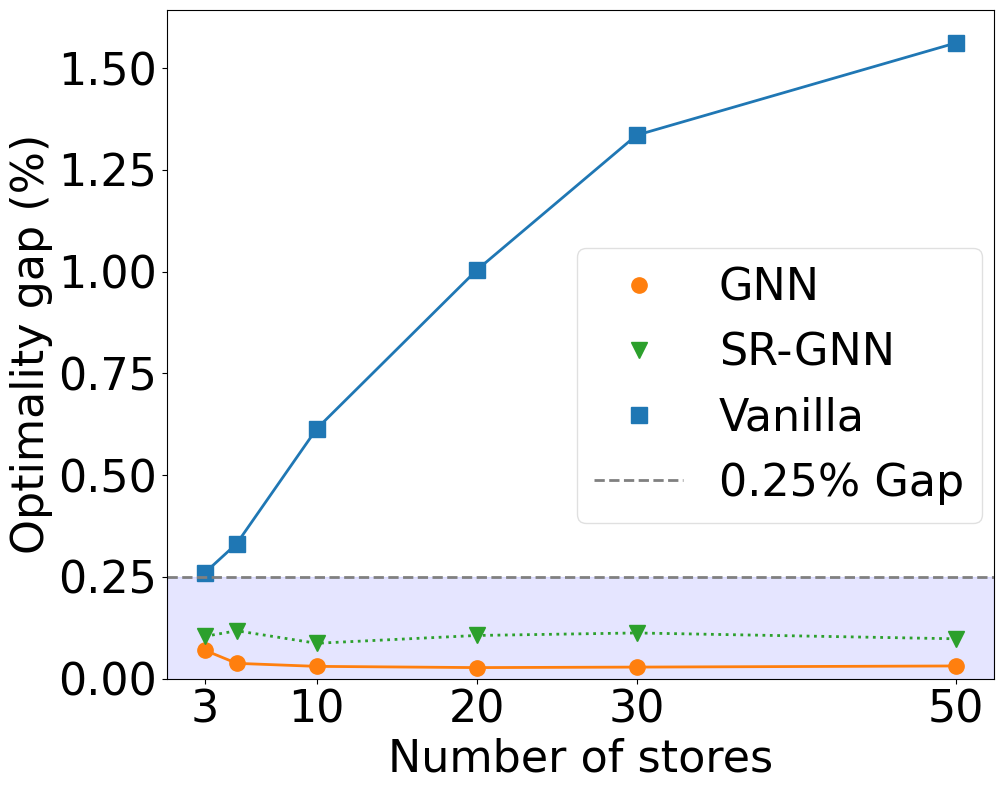

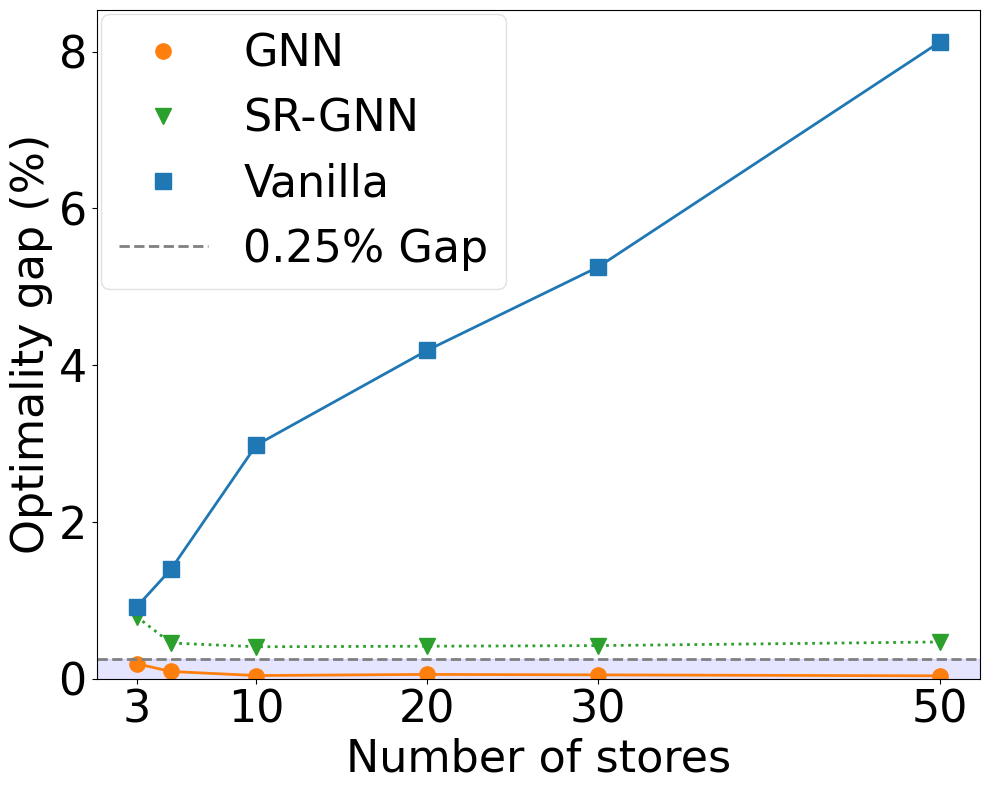

In [33]:
color_scheme = {
    "n_stores_per_store_net": "#2ca02c",
    "n_stores_shared_net": "#ff7f0e",
    "vanilla_n_stores": "#1f77b4"
}

gap_threshold = 0.25
marker_size = 11
line_width = 2

df['Optimality Gap %'] = ((df['Test Loss'] - optimal_loss) / optimal_loss) * 100
df.insert(df.columns.get_loc(df.columns[-1]), 'Optimality Gap %', df.pop('Optimality Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

arch_rename_map = {
    "n_stores_per_store_net": "SR-GNN",
    "n_stores_shared_net": "GNN",
    "vanilla_n_stores": "Vanilla"
}
df_to_print = df.copy()
df_to_print['Architecture Class'] = df_to_print['Architecture Class'].replace(arch_rename_map)
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

arch_styles = {
    "n_stores_shared_net":    {"color": color_scheme['n_stores_shared_net'], "linestyle": "-",  "marker": "o", "label": "GNN"},
    "n_stores_per_store_net": {"color": color_scheme["n_stores_per_store_net"], "linestyle": "-", "marker": "v", "label": "SR-GNN"},
    "vanilla_n_stores":       {"color": color_scheme["vanilla_n_stores"],   "linestyle": "-",  "marker": "s", "label": "Vanilla"},
}
arch_pretty_names = {
    "n_stores_shared_net": "GNN",
    "n_stores_per_store_net": "SR-GNN",
    "vanilla_n_stores": "Vanilla"
}
pretty_to_orig = {v: k for k, v in arch_rename_map.items()}

font_size = 32
xtick_values = [3, 10, 20, 30, 50]

plot_filenames = []
for idx, sample_size in enumerate(sample_sizes):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size].copy()
    df_sample['Architecture Class'] = df_sample['Architecture Class'].replace(arch_rename_map)
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Optimality Gap %'].min().unstack()
    
    for column in pivot_df.columns:
        if column == "GNN":
            style = {"color": color_scheme["n_stores_shared_net"], "linestyle": "-", "marker": "o", "label": "GNN"}
        elif column == "Vanilla":
            style = {"color": color_scheme["vanilla_n_stores"], "linestyle": "-", "marker": "s", "label": "Vanilla"}
        else:
            style = {"color": color_scheme["n_stores_per_store_net"], "linestyle": ":", "marker": "v", "label": column}
        ax.plot(
            pivot_df.index.to_numpy(),
            pivot_df[column].to_numpy(),
            marker=style["marker"],
            label=style["label"],
            color=style["color"],
            linestyle=style["linestyle"],
            markersize=marker_size,
            linewidth=line_width
        )
    ax.axhspan(-0.05, gap_threshold, color='blue', alpha=0.1)
    ax.axhline(y=gap_threshold, color='gray', linestyle='--', alpha=1.0, label=f'{gap_threshold}% Gap', linewidth=line_width)
    
    ax.set_xlabel('Number of stores', fontsize=font_size)
    ax.set_ylabel('Optimality gap (%)', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_xticks(xtick_values)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.set_ylim(bottom=-0.0)
    custom_lines = [
        plt.Line2D([0], [0], color=color_scheme["n_stores_shared_net"], linestyle="none", marker="o", label="GNN", markersize=marker_size),
        plt.Line2D([0], [0], color=color_scheme["n_stores_per_store_net"], linestyle="none", marker="v", label="SR-GNN", markersize=marker_size),
        plt.Line2D([0], [0], color=color_scheme["vanilla_n_stores"], linestyle="none", marker="s", label="Vanilla", markersize=marker_size),
        plt.Line2D([0], [0], color='gray', linestyle='--', marker=None, label=f'{gap_threshold}% Gap', linewidth=line_width)
    ]
    ax.legend(
        handles=custom_lines,
        fontsize=font_size,
        loc='upper left',
        bbox_to_anchor=(0.49, 0.65) if idx == 1 else (0,1),
        borderaxespad=0.1,
        framealpha=0.6
    )
    plt.tight_layout()
    plt.show()
    pdf_filename = f"/Users/minuk.lee/Downloads/weight_sharing_sample_size_{sample_size}.pdf"
    fig.savefig(pdf_filename, format="pdf", bbox_inches="tight")
    plot_filenames.append(pdf_filename)

In [ ]:
# Calculate optimality gap
df['Optimality Gap %'] = ((df['Test Loss'] - optimal_loss) / optimal_loss) * 100
df.insert(df.columns.get_loc(df.columns[-1]), 'Optimality Gap %', df.pop('Optimality Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

# Keep only GNN (n_stores_shared_net) in the dataframe
df = df[df['Architecture Class'] == 'n_stores_shared_net']

arch_rename_map = {
    "n_stores_shared_net": "GNN"
}
df_to_print = df.copy()
df_to_print['Architecture Class'] = df_to_print['Architecture Class'].replace(arch_rename_map)
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

arch_styles = {
    "n_stores_shared_net": {"color": color_scheme["n_stores_shared_net"], "linestyle": "-", "marker": "o", "label": "GNN"}
}
arch_pretty_names = {
    "n_stores_shared_net": "GNN"
}
pretty_to_orig = {v: k for k, v in arch_rename_map.items()}

fig, axes = plt.subplots(1, 3, figsize=(17, 6))

font_size = 24
xtick_values = [3, 10, 20, 30, 50]
gap_threshold = 0.25  # Use variable for threshold

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size].copy()
    df_sample['Architecture Class'] = df_sample['Architecture Class'].replace(arch_rename_map)
    # Keep only GNN in the sample as well
    df_sample = df_sample[df_sample['Architecture Class'] == "GNN"]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Optimality Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        orig_col = pretty_to_orig.get(column, column)
        style = arch_styles.get(orig_col, {"color": None, "linestyle": "-", "marker": "o", "label": column})
        ax.plot(
            pivot_df.index.to_numpy(),
            pivot_df[column].to_numpy(),
            marker=style["marker"],
            label=style["label"],
            color=style["color"],
            linestyle="-"  # Use solid line
        )
    # Add 0.25% gap threshold region and line
    ax.axhspan(-0.05, gap_threshold, color='blue', alpha=0.1)
    ax.axhline(y=gap_threshold, color='gray', linestyle='--', alpha=1.0, label=f'{gap_threshold}% Gap')
    
    ax.set_xlabel('Number of Stores', fontsize=font_size)
    if idx == 0:
        ax.set_ylabel('Optimality Gap(%)', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_title(f'Sample Size: {sample_size}', fontsize=font_size)
    ax.set_xticks(xtick_values)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()
pdf_filename = "/user/ml4723/Prj/NIC/Plots/weight_sharing_zoomin.pdf"
fig.savefig(pdf_filename, format="pdf", bbox_inches="tight")

    # of stores  train_dev_sample_and_batch_size Architecture Class  n_stores  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                                                                                                      path  master  Optimality Gap %
0             3                              128                GNN         3    6.533234  6.607551   6.542469  /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e11dd_00123_123_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-05-10_12-21-53     NaN          0.190946
6             3                             1024                GNN         3    6.511566  6.566057   6.534572  /Users/minuk.lee/Downloads/Neural_inventory_contro

NameError: name 'color_scheme' is not defined

In [ ]:
import numpy as np

mode = "test"
setting_name = 'n_stores_lost_demand_optimal'

test_loss_column = 'Test Loss'
test_loss_filename = 'n_stores_lost_demand_optimal_test_loss.txt'
test_losses = []

models = []
skip_mask = []
for _, row in df.iterrows():
    model_path = str(row['path']) + '/model.pt'
    test_loss_path = str(row['path']) + "/" + test_loss_filename
    models.append(model_path)
    if os.path.exists(test_loss_path):
        skip_mask.append(True)
    else:
        skip_mask.append(False)

gpus = [0]

def run_main_run(model_path, gpu_idx):
    try:
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/Users/minuk.lee/opt/anaconda3/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode,
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for i, path in enumerate(models):
        if skip_mask[i]:
            continue
        while len(futures) >= 1 * len(gpus):
            done, not_done = concurrent.futures.wait(
                futures,
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, gpu_idx))
        gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)



Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_weight_sharing/n_stores_per_store_net/run_2025-04-28_11-53-08/run_e187f_00005_5_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.00_2025-04-28_11-53-10/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_weight_sharing/n_stores_per_store_net/run_2025-04-28_11-53-08/run_e187f_00038_38_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.0_2025-04-28_11-53-10/model.pt


In [38]:
import pandas as pd

columns = [
    ('# of stores', 'Number of stores'),
    ('train_dev_sample_and_batch_size', 'Training scenarios (#)'),
    ('Architecture Class', 'Architecture Class'),
    ('Learning Rate', 'Learning rate'),
    ('master', 'Units per layer (#)'),
    ('Train Loss', 'Train loss'),
    ('Dev Loss', 'Dev loss'),
    ('Test Loss', 'Test loss'),
    ('Optimality Gap %', 'Test gap (%)')
]

arch_map = {
    'n_stores_shared_net': 'GNN',
    'n_stores_per_store_net': 'SR_GNN',
    'vanilla_n_stores': 'Vanilla'
}
arch_order = ['GNN', 'SR_GNN', 'Vanilla']

df_table = df.copy()

if 'Architecture Class' in df_table.columns:
    df_table['Architecture Class'] = df_table['Architecture Class'].map(arch_map).fillna(df_table['Architecture Class'])

for col, _ in columns:
    if col not in df_table.columns:
        df_table[col] = '-'
    if col == 'master':
        df_table[col] = df_table[col].apply(lambda x: str(int(x)) if pd.notnull(x) and x != '-' else '-')

df_table = df_table[[col for col, _ in columns]]
df_table.columns = [name for _, name in columns]

float_cols = ['Train loss', 'Dev loss', 'Test loss', 'Relative test loss (%)']
for col in float_cols:
    if col in df_table.columns:
        df_table[col] = pd.to_numeric(df_table[col], errors='coerce').map(lambda x: f"{x:.2f}" if pd.notnull(x) else '-')

df_table = df_table.fillna('-')

# Sort by 'Number of stores', 'Training scenarios (#)', then 'Architecture Class' (custom order)
if 'Architecture Class' in df_table.columns:
    df_table['Architecture Class'] = pd.Categorical(df_table['Architecture Class'], categories=arch_order, ordered=True)
    df_table = df_table.sort_values(
        by=['Number of stores', 'Training scenarios (#)', 'Architecture Class'],
        key=lambda x: pd.to_numeric(x, errors='coerce') if x.name in ['Number of stores', 'Training scenarios (#)'] else x
    )
else:
    df_table = df_table.sort_values(
        by=['Number of stores', 'Training scenarios (#)'],
        key=lambda x: pd.to_numeric(x, errors='coerce')
    )

# Apply formatting to 'Test gap (%)' column: if value < 0.25, show '<0.25', else round to 2 decimals
test_gap_col = 'Test gap (%)'
if test_gap_col in df_table.columns:
    def format_test_gap(val):
        try:
            num = float(val)
            if num < 0.25:
                return '<0.25'
            else:
                return f"{round(num, 2):.2f}"
        except:
            return val
    df_table[test_gap_col] = df_table[test_gap_col].map(format_test_gap)



print(df_table.to_string(index=False))

 Number of stores  Training scenarios (#) Architecture Class  Learning rate Units per layer (#) Train loss Dev loss Test loss Test gap (%)
                3                     128                GNN         0.0100                   -       6.53     6.61      6.54        <0.25
                3                     128             SR_GNN         0.0100                   -       6.54     6.61      6.58         0.74
                3                     128            Vanilla         0.0001                 128       6.50     6.64      6.59         0.92
                3                    1024                GNN         0.0100                   -       6.51     6.57      6.54        <0.25
                3                    1024             SR_GNN         0.0010                   -       6.49     6.57      6.54        <0.25
                3                    1024            Vanilla         0.0100                 128       6.51     6.58      6.55         0.27
                3          